<a href="https://colab.research.google.com/github/lxzjlu/Deep-Learning-Practice/blob/main/test1_resnet_20230713_twonet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as py
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt
import numpy as np

#import gradio as gr

超参数调整

batch_size减小 使得运算速度逐渐变慢  但是模型测试精度有一定提升

batch_size = 64
Epoch = 20
learning_rate = 0.01
num_classes = 10
训练精度 95.92%
测试精度 65.50% 严重过拟合

batch_size = 64
Epoch = 20
learning_rate = 0.01
num_classes = 10
训练精度 74.49%
测试精度 67.45%

batch_size = 16
Epoch = 5
learning_rate = 0.01
num_classes = 10
训练精度 72.94%
测试精度 72.58%

batch_size = 16
Epoch = 10
learning_rate = 0.01
num_classes = 10
训练精度 84.10%
测试精度 75.80% 开始过拟合

batch_size = 8
Epoch = 10
learning_rate = 0.01
num_classes = 10
训练精度 77.88%
测试精度 72.12%


数据集增强处理

训练集 采用transform1 和 transform2 数据处理结果进行拼接 对测试集数据进行翻倍
测试集 采用transform2 数据进行处理
结果 训练精度85.11% 测试精度78.48%

训练集 仅采用transform1 进行数据强化
测试集 采用transform2 数据进行处理
结果 训练精度 76.10% 测试精度 52.61%  ！！！问题问题问题（为什么这个的训练精度 远小于 没有数据增强的精度）

训练集 采用transform1（增强版） 未翻倍
测试集 采用transform2 数据进行处理
结果 训练精度 90.79% 测试精度 76.27%（为什么图片变化大了，反而相同测试集上的测试精度没变）

训练集 采用transform2 进行数据处理
测试集 采用transform2 数据进行处理
结果 训练精度 90.95% 测试精度 75.21%（发生严重过拟合）

训练集 采用transform1（增强版） 和 transform2 数据处理结果进行拼接 对测试集数据进行翻倍
测试集 采用transform2 数据进行处理
结果 训练精度 74.06% 测试精度 75.69%   （learning_rate 0.01 考虑可能是太大了 调成0.005）

训练集 采用transform1（增强版） 和 transform2 数据处理结果进行拼接 对测试集数据进行翻倍
测试集 采用transform2 数据进行处理
结果 训练精度 73.39% 测试精度 76.12%   （learning_rate 0.005 考虑可能是epoch太小了）

训练集 采用transform1（增强版） 和 transform2 数据处理结果进行拼接 对测试集数据进行翻倍
测试集 采用transform2 数据进行处理
结果 训练精度 81.69% 测试精度  78.93%   （learning_rate 0.005 epoch = 25）



Resnet-18 残差连接与否 效果测试

训练集 采用transform1（增强版） 和 transform2 数据处理结果进行拼接 对测试集数据进行翻倍 测试集 采用transform2 数据进行处理 结果 训练精度 81.69% 测试精度 78.93% （learning_rate 0.005 epoch = 25） 但是loss还是很大很飘  考虑添加学习率自调整模块

添加学习率自调整模块 以及 增加 epoch  用增强版的数据增强方法
batch_size = 16
Epoch = 80
learning_rate = 0.01
训练精度 87.45 %
测试精度 81.70 %

取消增强版的数据增强方法
数据增强只保留 随即裁减和随即旋转
batch_size = 16
Epoch = 80
learning_rate = 0.01
训练精度  94.65%
测试精度  81.82%

数据增强只保留 随即裁减和随即旋转
batch_size = 32
Epoch = 80
learning_rate = 0.01
训练精度   %
测试精度   %

In [ ]:
##################################
#超参数定义
batch_size = 32
Epoch = 80
learning_rate = 0.01
num_classes = 10

In [ ]:
##################################
#输入数据处理   训练集 测试集

#数据增强
# transform1 = transforms.Compose([
#     #图形尺寸填充 填充至36x36
#     transforms.Pad(4),
#     #随机水平翻转
#     transforms.RandomHorizontalFlip(),
#     #随机裁剪 裁剪至32x32
#     transforms.RandomCrop(32),
#     #转换至Tensor
#     transforms.ToTensor(),
#     ])
#数据增强 完整版
transform1 = transforms.Compose([
    #图形尺寸填充 填充至36x36
    transforms.Pad(4),
    # #随机水平翻转
    # transforms.RandomHorizontalFlip(),
    # # 随机垂直翻转
    # transforms.RandomVerticalFlip(),
    # 随机旋转65
    transforms.RandomRotation(30),
    #随机裁剪 裁剪至32x32
    transforms.RandomCrop(32),
    # # 随机亮度调整
    # transforms.ColorJitter(brightness=0.2),
    # # 随机对比度调整
    # transforms.ColorJitter(contrast=0.2),
    # # 随机饱和度调整
    # transforms.ColorJitter(saturation=0.2),
    # # 随机色相调整
    # transforms.ColorJitter(hue=0.1),
    #转换至Tensor
    transforms.ToTensor(),
    ])

#数据处理
transform2 = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#训练集数据导入 用两种方法实现数据集扩充
trainset1 = torchvision.datasets.CIFAR10(root='./data',train=True,
                     download=True, transform=transform1)
trainset2 = torchvision.datasets.CIFAR10(root='./data',train=True,
                     download=True, transform=transform2)
concat_trainset = torch.utils.data.ConcatDataset([trainset1, trainset2])
trainloader = torch.utils.data.DataLoader(concat_trainset, batch_size=batch_size,
                     shuffle=True, num_workers=2)

#训练集数据导入 仅用transform1 进行训练集数据增强
# trainset = torchvision.datasets.CIFAR10(root='./data',train=True,
#                      download=True, transform=transform2)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                      shuffle=True, num_workers=2)

#测试集数据导入 仅采用正常数据处理方法
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                     download=True, transform=transform2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                     shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:13<00:00, 12967449.84it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
############################################
#训练集数据导入
dataiter = iter(trainloader)
images, labels = next(dataiter)

In [ ]:
##############################
#网络定义Resnet

#定义残差块
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):  #需要判断是否需要1×1的卷积
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                    kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                    kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                        kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X                                                 ###############################################可以去掉 不存在残差
        return F.relu(Y)



def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk



class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        self.b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
        self.b3 = nn.Sequential(*resnet_block(64, 128, 2))
        self.b4 = nn.Sequential(*resnet_block(128, 256, 2))
        self.b5 = nn.Sequential(*resnet_block(256, 512, 2))
        self.linear = nn.Linear(512, 10)
        self.Aavgpool = nn.AdaptiveAvgPool2d((1,1))





    def forward(self, x):
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        x = self.b4(x)
        x = self.b5(x)
        x = self.Aavgpool(x)
        x = torch.flatten(x,1)
        x = self.linear(x)

        return x

net = Net()

In [ ]:
##########################
#定义损失函数 和 梯度计算

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=10, gamma=0.95)

In [ ]:
#GPU训练
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
!nvidia-smi

cuda:0
Thu Jul 13 11:44:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+

In [ ]:
###########################
#训练过程

#GPU训练
#net.to(device)
net = net.cuda()
#存储损失与精度
loss_history = []
accuracy_history = []
loss_times_history = []

for epoch in range(Epoch):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    scheduler.step()
    for i, data in enumerate(trainloader, 0):
        #获取输入

        inputs, labels = data
        #inputs.to(device)
        inputs = inputs.cuda()
        #labels.to(device)
        labels = labels.cuda()
        #梯度置零
        optimizer.zero_grad()

        #前向计算
        outputs = net(inputs)
        #获取损失
        loss = criterion(outputs, labels)
        #计算梯度
        loss.backward()
        optimizer.step()
        #累计损失
        running_loss += loss.item()
        loss_times_history.append(loss.item())
        # 计算准确率
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()



        #每200次循环输出打印一次
        if i % 200 == 199:    # print every 2000 mini-batches
            print('Epoch: {}, Step: {}, Step_total: {}, Loss:{:.3f}'.format(epoch+1, i+1, len(trainloader), loss.item()))

    #计算各epoch中的平均损失值和准确率
    avg_loss = running_loss / len(trainloader)
    accuracy = 100.0 * correct_train / total_train
    #存储平均损失值和准确率
    loss_history.append(avg_loss)
    accuracy_history.append(accuracy)
    #输出学习率
    print(f"Epoch [{epoch+1}/{Epoch}], Learning Rate: {scheduler.get_lr()[0]}")




print('Finished Training')


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: 1, Step: 200, Step_total: 3125, Loss:2.065
Epoch: 1, Step: 400, Step_total: 3125, Loss:1.717
Epoch: 1, Step: 600, Step_total: 3125, Loss:1.988
Epoch: 1, Step: 800, Step_total: 3125, Loss:1.703
Epoch: 1, Step: 1000, Step_total: 3125, Loss:1.765
Epoch: 1, Step: 1200, Step_total: 3125, Loss:1.458
Epoch: 1, Step: 1400, Step_total: 3125, Loss:1.642
Epoch: 1, Step: 1600, Step_total: 3125, Loss:1.482
Epoch: 1, Step: 1800, Step_total: 3125, Loss:1.575
Epoch: 1, Step: 2000, Step_total: 3125, Loss:1.507
Epoch: 1, Step: 2200, Step_total: 3125, Loss:1.620
Epoch: 1, Step: 2400, Step_total: 3125, Loss:1.540
Epoch: 1, Step: 2600, Step_total: 3125, Loss:1.554
Epoch: 1, Step: 2800, Step_total: 3125, Loss:1.666
Epoch: 1, Step: 3000, Step_total: 3125, Loss:1.164
Epoch [1/80], Learning Rate: 0.01


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: 2, Step: 200, Step_total: 3125, Loss:1.189
Epoch: 2, Step: 400, Step_total: 3125, Loss:1.140
Epoch: 2, Step: 600, Step_total: 3125, Loss:1.186
Epoch: 2, Step: 800, Step_total: 3125, Loss:1.489
Epoch: 2, Step: 1000, Step_total: 3125, Loss:1.492
Epoch: 2, Step: 1200, Step_total: 3125, Loss:1.274
Epoch: 2, Step: 1400, Step_total: 3125, Loss:1.315
Epoch: 2, Step: 1600, Step_total: 3125, Loss:0.971
Epoch: 2, Step: 1800, Step_total: 3125, Loss:1.356
Epoch: 2, Step: 2000, Step_total: 3125, Loss:1.257
Epoch: 2, Step: 2200, Step_total: 3125, Loss:1.102
Epoch: 2, Step: 2400, Step_total: 3125, Loss:1.408
Epoch: 2, Step: 2600, Step_total: 3125, Loss:1.165
Epoch: 2, Step: 2800, Step_total: 3125, Loss:1.166
Epoch: 2, Step: 3000, Step_total: 3125, Loss:0.936
Epoch [2/80], Learning Rate: 0.01
Epoch: 3, Step: 200, Step_total: 3125, Loss:1.297
Epoch: 3, Step: 400, Step_total: 3125, Loss:0.798
Epoch: 3, Step: 600, Step_total: 3125, Loss:1.175
Epoch: 3, Step: 800, Step_total: 3125, Loss:1.152
Epoch

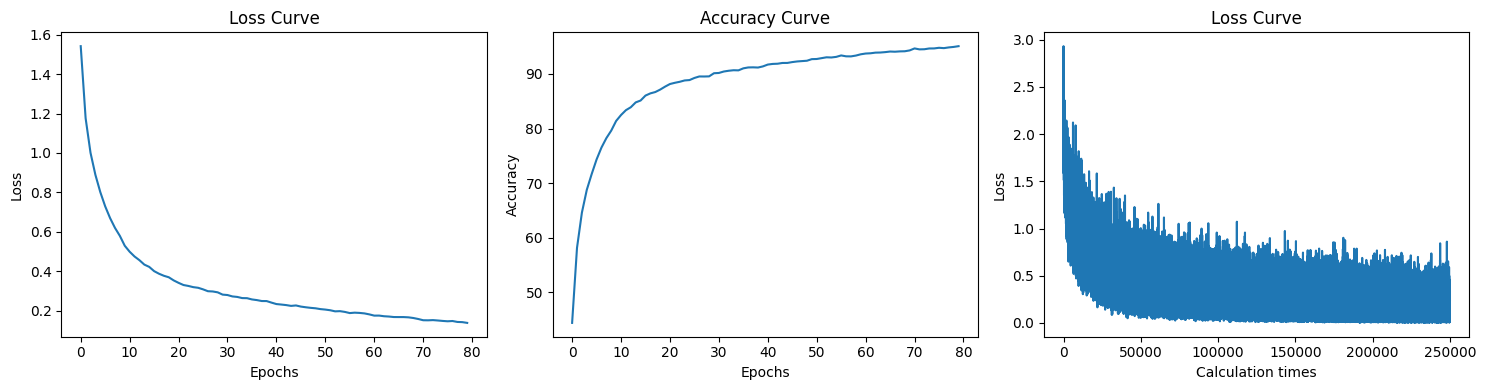

In [ ]:
###############################
#绘制损失和准确率曲线

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
#loss_history_1 = [loss + 1 for loss in loss_history]
plt.plot(range(Epoch), loss_history)
#plt.plot(range(Epoch), loss_history_1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')

plt.subplot(1, 3, 2)
plt.plot(range(Epoch), accuracy_history)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')


plt.subplot(1, 3, 3)
times = len(trainloader)*Epoch
plt.plot(range(times), loss_times_history)
plt.xlabel('Calculation times')
plt.ylabel('Loss')
plt.title('Loss Curve')

plt.tight_layout()
plt.show()


In [ ]:
##################################
#测试
net.eval()
#总精度及各类精度相关参数定义
correct = 0
total = 0
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

#测试数据集运行
with torch.no_grad():
  for data in testloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    for label, prediction in zip(labels, predicted):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


print('Accuracy of the net on the train iamges is {:.2f} %'.format(accuracy_history[-1]))
print('Accuracy of the net on the test iamges is {:.2f} %'.format(100 * correct / total))
print('\n')
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy of the net on the train iamges is 95.07 %
Accuracy of the net on the test iamges is 81.29 %


Accuracy for class: plane is 83.9 %
Accuracy for class: car   is 88.6 %
Accuracy for class: bird  is 75.3 %
Accuracy for class: cat   is 69.9 %
Accuracy for class: deer  is 75.4 %
Accuracy for class: dog   is 71.0 %
Accuracy for class: frog  is 85.8 %
Accuracy for class: horse is 86.3 %
Accuracy for class: ship  is 88.0 %
Accuracy for class: truck is 88.7 %


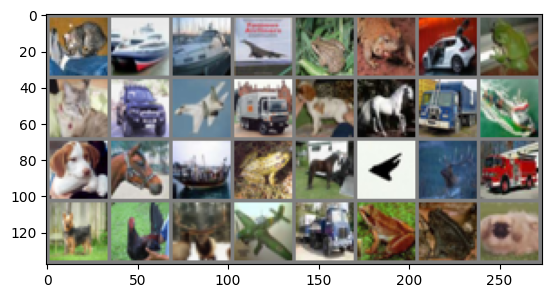

Truth Labels:  cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship  dog   horse ship  frog  horse plane deer  truck dog   bird  deer  plane truck frog  frog  dog  
Predicted Labels:  cat   ship  ship  plane frog  frog  cat   frog  cat   car   plane truck dog   horse truck ship  dog   horse ship  frog  horse bird  deer  truck deer  bird  cat   plane truck frog  frog  dog  


In [ ]:
############################
#可视化
dataiter = iter(testloader)
images, labels = next(dataiter)

#打印测试集照片
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
imshow(torchvision.utils.make_grid(images))

#输出真实标签
print('Truth Labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

#输出预测标签
images = images.cuda()
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted Labels: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(batch_size)))

In [ ]:
class Residual_1(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):  #需要判断是否需要1×1的卷积
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                    kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                    kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                        kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        # Y += X                                                 ###############################################可以去掉 不存在残差
        return F.relu(Y)



def resnet_block_1(input_channels, num_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual_1(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual_1(num_channels, num_channels))
    return blk



class Net_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        self.b2 = nn.Sequential(*resnet_block_1(64, 64, 2, first_block=True))
        self.b3 = nn.Sequential(*resnet_block_1(64, 128, 2))
        self.b4 = nn.Sequential(*resnet_block_1(128, 256, 2))
        self.b5 = nn.Sequential(*resnet_block_1(256, 512, 2))
        self.linear = nn.Linear(512, 10)
        self.Aavgpool = nn.AdaptiveAvgPool2d((1,1))





    def forward(self, x):
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        x = self.b4(x)
        x = self.b5(x)
        x = self.Aavgpool(x)
        x = torch.flatten(x,1)
        x = self.linear(x)

        return x

net_1 = Net_1()

In [ ]:
##########################
#定义损失函数 和 梯度计算

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net_1.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=10, gamma=0.95)

In [ ]:
###########################
#训练过程

#GPU训练
#net.to(device)
net_1 = net_1.cuda()
#存储损失与精度
loss_history_1 = []
accuracy_history_1 = []
loss_times_history_1 = []

for epoch in range(Epoch):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    scheduler.step()
    for i, data in enumerate(trainloader, 0):
        #获取输入

        inputs, labels = data
        #inputs.to(device)
        inputs = inputs.cuda()
        #labels.to(device)
        labels = labels.cuda()
        #梯度置零
        optimizer.zero_grad()

        #前向计算
        outputs = net_1(inputs)
        #获取损失
        loss = criterion(outputs, labels)
        #计算梯度
        loss.backward()
        optimizer.step()
        #累计损失
        running_loss += loss.item()
        loss_times_history_1.append(loss.item())
        # 计算准确率
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()



        #每200次循环输出打印一次
        if i % 200 == 199:    # print every 2000 mini-batches
            print('Epoch: {}, Step: {}, Step_total: {}, Loss:{:.3f}'.format(epoch+1, i+1, len(trainloader), loss.item()))

    #计算各epoch中的平均损失值和准确率
    avg_loss = running_loss / len(trainloader)
    accuracy = 100.0 * correct_train / total_train
    #存储平均损失值和准确率
    loss_history_1.append(avg_loss)
    accuracy_history_1.append(accuracy)
    #输出学习率
    print(f"Epoch [{epoch+1}/{Epoch}], Learning Rate: {scheduler.get_lr()[0]}")




print('Finished Training')

Epoch: 1, Step: 200, Step_total: 3125, Loss:1.916
Epoch: 1, Step: 400, Step_total: 3125, Loss:1.568
Epoch: 1, Step: 600, Step_total: 3125, Loss:1.547
Epoch: 1, Step: 800, Step_total: 3125, Loss:1.610
Epoch: 1, Step: 1000, Step_total: 3125, Loss:1.741
Epoch: 1, Step: 1200, Step_total: 3125, Loss:1.497
Epoch: 1, Step: 1400, Step_total: 3125, Loss:1.651
Epoch: 1, Step: 1600, Step_total: 3125, Loss:1.377
Epoch: 1, Step: 1800, Step_total: 3125, Loss:1.620
Epoch: 1, Step: 2000, Step_total: 3125, Loss:1.294
Epoch: 1, Step: 2200, Step_total: 3125, Loss:1.574
Epoch: 1, Step: 2400, Step_total: 3125, Loss:1.553
Epoch: 1, Step: 2600, Step_total: 3125, Loss:1.358
Epoch: 1, Step: 2800, Step_total: 3125, Loss:1.057
Epoch: 1, Step: 3000, Step_total: 3125, Loss:1.638
Epoch [1/80], Learning Rate: 0.01
Epoch: 2, Step: 200, Step_total: 3125, Loss:1.787
Epoch: 2, Step: 400, Step_total: 3125, Loss:1.818
Epoch: 2, Step: 600, Step_total: 3125, Loss:1.418
Epoch: 2, Step: 800, Step_total: 3125, Loss:1.348
Epoch

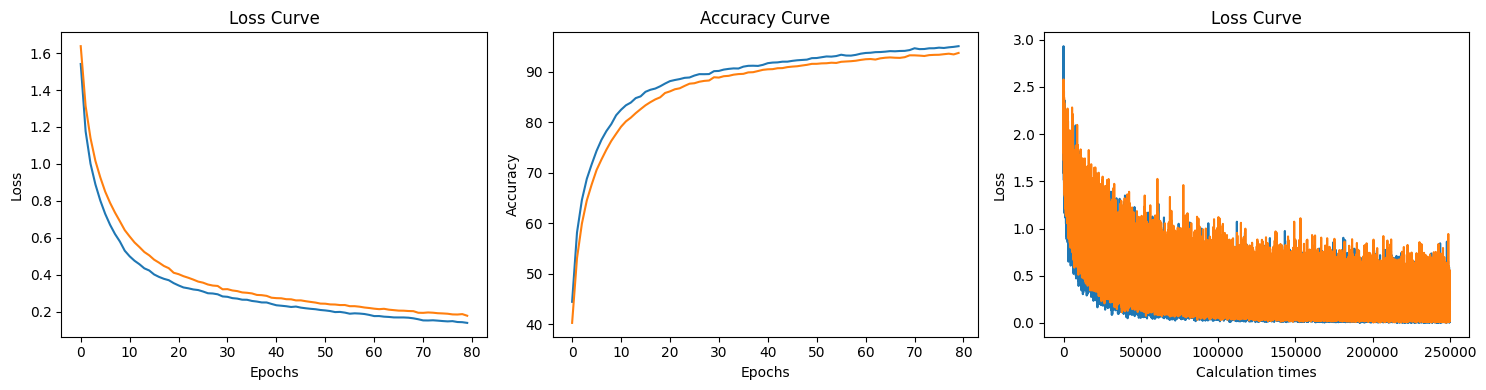

In [ ]:
#绘制损失和准确率曲线

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
#loss_history_1 = [loss + 1 for loss in loss_history]
plt.plot(range(Epoch), loss_history)
plt.plot(range(Epoch), loss_history_1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')

plt.subplot(1, 3, 2)
plt.plot(range(Epoch), accuracy_history)
plt.plot(range(Epoch), accuracy_history_1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')


plt.subplot(1, 3, 3)
times = len(trainloader)*Epoch
plt.plot(range(times), loss_times_history)
plt.plot(range(times), loss_times_history_1)
plt.xlabel('Calculation times')
plt.ylabel('Loss')
plt.title('Loss Curve')

plt.tight_layout()
plt.show()

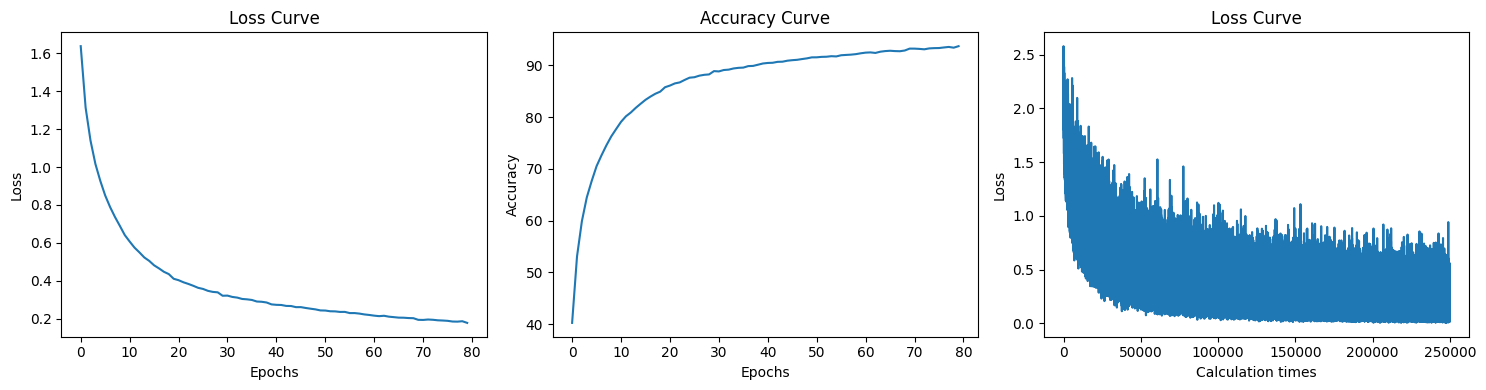

In [ ]:
#绘制损失和准确率曲线

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
#loss_history_1 = [loss + 1 for loss in loss_history]
# plt.plot(range(Epoch), loss_history)
plt.plot(range(Epoch), loss_history_1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')

plt.subplot(1, 3, 2)
# plt.plot(range(Epoch), accuracy_history)
plt.plot(range(Epoch), accuracy_history_1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')


plt.subplot(1, 3, 3)
times = len(trainloader)*Epoch
# plt.plot(range(times), loss_times_history)
plt.plot(range(times), loss_times_history_1)
plt.xlabel('Calculation times')
plt.ylabel('Loss')
plt.title('Loss Curve')

plt.tight_layout()
plt.show()

In [ ]:
#测试
net_1.eval()
#总精度及各类精度相关参数定义
correct = 0
total = 0
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

#测试数据集运行
with torch.no_grad():
  for data in testloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    outputs = net_1(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    for label, prediction in zip(labels, predicted):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


print('Accuracy of the net on the train iamges is {:.2f} %'.format(accuracy_history_1[-1]))
print('Accuracy of the net on the test iamges is {:.2f} %'.format(100 * correct / total))
print('\n')
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy of the net on the train iamges is 93.73 %
Accuracy of the net on the test iamges is 81.18 %


Accuracy for class: plane is 83.8 %
Accuracy for class: car   is 89.0 %
Accuracy for class: bird  is 74.0 %
Accuracy for class: cat   is 64.2 %
Accuracy for class: deer  is 79.1 %
Accuracy for class: dog   is 74.5 %
Accuracy for class: frog  is 82.7 %
Accuracy for class: horse is 87.7 %
Accuracy for class: ship  is 89.1 %
Accuracy for class: truck is 87.7 %


保留残差连接
Accuracy of the net on the train iamges is 95.07 %
Accuracy of the net on the test iamges is 81.29 %


Accuracy for class: plane is 83.9 %
Accuracy for class: car   is 88.6 %
Accuracy for class: bird  is 75.3 %
Accuracy for class: cat   is 69.9 %
Accuracy for class: deer  is 75.4 %
Accuracy for class: dog   is 71.0 %
Accuracy for class: frog  is 85.8 %
Accuracy for class: horse is 86.3 %
Accuracy for class: ship  is 88.0 %
Accuracy for class: truck is 88.7 %


去除残差连接
Accuracy of the net on the train iamges is 93.73 %
Accuracy of the net on the test iamges is 81.18 %


Accuracy for class: plane is 83.8 %
Accuracy for class: car   is 89.0 %
Accuracy for class: bird  is 74.0 %
Accuracy for class: cat   is 64.2 %
Accuracy for class: deer  is 79.1 %
Accuracy for class: dog   is 74.5 %
Accuracy for class: frog  is 82.7 %
Accuracy for class: horse is 87.7 %
Accuracy for class: ship  is 89.1 %
Accuracy for class: truck is 87.7 %

In [ ]:
# !pip install gradio
import itertools
import gradio as gr
from PIL import Image
def print_label(input_dex):
  plt.figure(figsize=(15, 4))
  plt.subplot(1, 3, 1)
  plt.plot(range(Epoch), loss_history)
  plt.plot(range(Epoch), loss_history_1)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Loss Curve')

  plt.subplot(1, 3, 2)
  plt.plot(range(Epoch), accuracy_history)
  plt.plot(range(Epoch), accuracy_history_1)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Accuracy Curve')


  plt.subplot(1, 3, 3)
  times = len(trainloader)*Epoch
  plt.plot(range(times), loss_times_history)
  plt.plot(range(times), loss_times_history_1)
  plt.xlabel('Calculation times')
  plt.ylabel('Loss')
  plt.title('Loss Curve')



#   plt.tight_layout()
#   plt.show()
# print_label(5)

  curve_fig = "curve.png"
  plt.savefig(curve_fig)
  curve = Image.open(curve_fig)
  k = int(int(input_dex)/batch_size)
  m = int(int(input_dex)%batch_size)
  data_iter = iter(testloader)
  images, labels = next(itertools.islice(data_iter, k, k+1))
  image = images[m].numpy()
  image = np.transpose(image, (1,2,0))
  show_img = image
  imagebatch = image.reshape(-1,3,32,32)
  # 转换为torch tensor
  image_tensor = torch.from_numpy(imagebatch)
  image_tensor = image_tensor.cuda()
  # 调用模型进行评估
  net.eval()
  output = net(image_tensor)
  precise, predicted = torch.max(output.data, 1)
  pre = predicted.cpu().numpy()

  return curve,classes[pre[0]],classes[labels[m].numpy()],show_img



demo = gr.Interface(fn=print_label,
                    inputs=gr.Textbox(label="Input 0-9999"),
                    outputs=[gr.outputs.Image(type="pil",label="loss and acc"),
                    gr.Textbox(label="predict label"),
                    gr.Textbox(label="true label"),
                    gr.outputs.Image(type="pil",label="Image")]
                    )
demo.launch()

<ipython-input-31-ce756da5ec82>:62: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  outputs=[gr.outputs.Image(type="pil",label="loss and acc"),
<ipython-input-31-ce756da5ec82>:65: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  gr.outputs.Image(type="pil",label="Image")]


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>